# Program - Plot profiles at a given lat/lon in TaiESM simulation

**Content:**
- read TaiESM hindcast data
- Plot profiles given lat/lon

**Author**: Yi-Hsuan Chen (yihsuan@umich.edu)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types
import nc_time_axis

import yhc_module as yhc
import read_data_big as read_data    ## on my Mac


xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

ERROR 1: PROJ: proj_create_from_database: Open of /lfs/opt/anaconda3/share/proj failed


## Functions

In [2]:
#yhc.lib('fdef')

### read_taiesm_hindcast_ds

In [3]:
#####################
#####################
#####################
def read_taiesm_hindcast_ds(icdate_and_files, 
                            icdata_option="ERA5",
                           ):

    func_name = "read_taiesm_hindcast_ds"

    #--- get icdate and file_dates
    if (icdate_and_files == "skjdfkjaskdjfk"):
        aa=0
    elif (icdate_and_files == "icdate_20010710_day1-3"):
        icdate = "20010710"
        file_dates = ["2001-07-10-00000", 
                      "2001-07-11-00000",
                      "2001-07-12-00000",
                     ]
    else:
      error_msg = f"ERROR: function [{func_name}] does not support icdate_and_files=[{icdate_and_files}]."
      raise ValueError(error_msg)

    #--- read ds
    #ds1 = read_data.read_TaiESM1_hindcast_icdate_files(choice="custom_state_3hr", icdate=icdate, file_dates=file_dates, icdata_option=icdata_option)
    #ds_state = subset_ds(ds=ds1, lat=lat, lon=lon)

    ds_state = read_data.read_TaiESM1_hindcast_icdate_files(choice="custom_state_3hr", icdate=icdate, file_dates=file_dates, icdata_option=icdata_option)
    ds_Ttend = read_data.read_TaiESM1_hindcast_icdate_files(choice="custom_Ttend_3hr", icdate=icdate, file_dates=file_dates, icdata_option=icdata_option)
    ds_Qtend = read_data.read_TaiESM1_hindcast_icdate_files(choice="custom_Qtend_3hr", icdate=icdate, file_dates=file_dates, icdata_option=icdata_option)
    ds_2d = read_data.read_TaiESM1_hindcast_icdate_files(choice="custom_2d_1hr"   , icdate=icdate, file_dates=file_dates, icdata_option=icdata_option)
    
    return ds_state, ds_Ttend, ds_Qtend, ds_2d

#####################
#####################
#####################
def subset_ds(ds, lat, lon):
    
    lat_index, lon_index = get_lat_lon_indexes(ds, lat, lon)
    ds_subset = ds.isel(lat=lat_index, lon=lon_index)

    return ds_subset

#####################
#####################
#####################
def get_lat_lon_indexes(ds, lat, lon):
    lat_index = abs(ds['lat'] - lat).argmin().item()
    lon_index = abs(ds['lon'] - lon).argmin().item()

    return lat_index, lon_index

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    icdate_and_files = "icdate_20010710_day1-3"
    ds_state, ds_Ttend, ds_Qtend, ds_2d = read_taiesm_hindcast_ds(icdate_and_files, icdata_option="ERA5_DYCOMS")

#ds_2d

### plot_scm_profiles_1vNt

In [4]:
def plot_scm_profiles_1vNt (ds, variable_names, 
                            tt1=0, tt2=6, jj=0, ii=0, ylim_p=[1000,850], xlim=None,
                            title = "TaiESM1 SCM RF01 :", 
                            yy_option='lev',
                            do_units=True,
                            units_custom=None,
                           ):
    """
    ----------------------
    Description:
      Given a SCM dataset and variable names, plot the time steps for each variable

    Input arguments:
      ds: a Xarray Dataset
      variable_names: a list containing the variables in the ds
      tt1, tt2: plot the time indexes from tt1 to tt2
      jj, ii: indexes for lat and lon, respectively
      ylim_p: upper and lower limit of y axis
      xlim  : upper and lower limit of each variable
      title : title on each plot
      do_units: do unit conversion using yhc.unit_convert
    
    Return:
      a plot

    Example:
      import yhc_module as yhc
      
      ttend_min=-100 ; ttend_max=300

      xlim_custom = {
            "T": [283, 295],
            "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], 
                    }
      plot_scm_profiles_1vNt(ds_scm, ['T','TTEND_TOT','MACPDT','MPDT'], xlim=xlim_custom)

    Date created: 2024-04-18
    ----------------------
    """
    fig, axes = plt.subplots(1, len(variable_names), figsize=(4*len(variable_names), 4))

    for i, var_name in enumerate(variable_names):
        ds1 = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
        var_data = ds1[var_name][tt1:tt2, :, jj, ii]
        if (do_units): var_data = yhc.unit_convert(var_data, units_custom=units_custom)
        units = var_data.attrs['units']
        
        ax = axes[i]

        if xlim is not None and var_name in xlim and xlim[var_name] is not None:
            xlim_var = xlim[var_name]
        else:    
            xlim_var = None

        #--- change lev values to pressure
        if (yy_option == "play"):
            ds1 = yhc.diagnose_var(ds, ['play'])
            #print(ds1['play'][tt1, :, jj, ii])
            var_data = var_data.assign_coords(lev=ds1['play'][tt1, :, jj, ii].values)
            ylabel = "Pressure (hPa)"
        else:
            ylabel = "Nominal Pressure (hPa)"
        
        var_data.plot.line(ax=ax, y='lev', yincrease=False, ylim=ylim_p, xlim=xlim_var, marker='o', markersize=4)
        
        ax.grid(True)
        ax.minorticks_on() 
        ax.grid(which='major', color='gray', linestyle='-.', linewidth=0.5)        # set both X and Y grids

        lat = ds1.lat[jj].values ; lon = ds1.lon[ii].values
        ax.set_title(f"{title} {var_name} \n (lat,lon)=({lat:.2f}, {lon:.2f})")
        ax.set_ylabel(ylabel)

        # Retrieve the legend
        legend = ax.get_legend()
        
        # Adjust legend fontsize
        if legend:
            for text in legend.get_texts():
                text.set_fontsize(6)  # Set fontsize
    
    plt.tight_layout()
    plt.show()


### plot_scm_profiles_Nv1t

In [5]:
#####################
#####################
#####################
def set_profile_varnames (opt):
    """
    ----------------------
    Description:
       Return a dictionary variable that can be used in the function, plot_ds_var_profiles

    Input arguments:
       opt (str): option. Currently supported: [DT_budget, DQV_budget, DQL_budget, DQI_budget]

    Return:
       varnames (a dict)

    Example:
      import yhc_module as yhc
      varnames = set_profile_varnames('DT_budget')

    Date created: 2024-03-20
    ----------------------
    """

    func_name = "set_profile_varnames"

    #--- colors for each process
    color_tot = 'black' ; color_dyn = 'darkgray' ; color_PT = 'red' ; color_sum = color_PT
    color_ZM = 'blue'   ; color_CMF = 'cyan'     ; color_DPDLF = 'royalblue' ; color_SHDLF = 'skyblue'
    color_MACP = 'green' ; color_MP = 'limegreen' ; color_QRL = 'orange' ; color_QRS = 'pink' ; 
    color_vdiff = 'purple' ; color_gwd = 'yellow'
    
    #@@@@@@@@@@@@@@@@@
    if (opt == "DT_budget"):
        varnames = {
            'TTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [TTEND_TOT]'},
            'DTCORE': {'color':color_dyn, 'label': 'Dynamics [DTCORE]'},
            'PTTEND': {'color':color_PT, 'label': 'All phys [PTTEND]'},
            'DT_deep': {'color': color_ZM, 'label':'Deep convection [ZMDT+ZMMTT+EVAPTZM]'},
            'CMFDT': {'color': color_CMF, 'label': 'Shallow convection [CMFDT]'},
            'DPDLFT': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFT]'},
            'SHDLFT': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFT]'},
            'MACPDT': {'color':color_MACP, 'label':'Macrophysics [MACPDT]'},
            'MPDT': {'color':color_MP, 'label':'Microphysics [MPCT]'},
            'QRL': {'color':color_QRL, 'label': 'LW radiation [QRL]'},
            'QRS': {'color':color_QRS, 'label':'SW radiation [QRS]'},
            'DTV': {'color':color_vdiff, 'label': 'PBL & turbulence [DTV]'},
            'TTGWORO': {'color':color_gwd, 'label':'grav wave drag [TTGWORO]'},
            'DT_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQV_budget"):        
        varnames = {
            'QVTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QVTEND_TOT]'},
            'DQVCORE': {'color':color_dyn, 'label': 'Dynamics [DQVCORE]'},
            'PTEQ': {'color':color_PT, 'label': 'All phys [PTEQ]'},
            'DQV_deep': {'color': color_ZM, 'label':'Deep convection [ZMDQ+EVAPQZM]'},
            'CMFDQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDQ]'},
            'MACPDQ': {'color':color_MACP, 'label':'Macrophysics [MACPDQ]'},
            'MPDQ': {'color':color_MP, 'label':'Microphysics [MPDQ]'},
            'VD01': {'color':color_vdiff, 'label': 'PBL & turbulence [VD01]'},
            'DQV_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQL_budget"):           
        varnames = {
            'QLTEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QLTEND_TOT]'},
            'DQLCORE': {'color':color_dyn, 'label': 'Dynamics [DQLCORE]'},
            'PTECLDLIQ': {'color':color_PT, 'label': 'All phys [PTECLDLIQ]'},
            'ZMDLIQ': {'color': color_ZM, 'label':'Deep convection [ZMDLIQ]'},
            'CMFDLIQ': {'color': color_CMF, 'label': 'Shallow convection [CMFDLIQ]'},
            'DPDLFLIQ': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFLIQ]'},
            'SHDLFLIQ': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFLIQ]'},
            'MACPDLIQ': {'color':color_MACP, 'label':'Macrophysics [MACPDLIQ]'},
            'MPDLIQ': {'color':color_MP, 'label':'Microphysics [MPDLIQ]'},
            'VDCLDLIQ': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDLIQ]'},
            'DQL_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    elif (opt == "DQI_budget"):   
        varnames = {
            'QITEND_TOT': {'color':color_tot, 'label': 'Total=dyn+phys [QITEND_TOT]'},
            'DQICORE': {'color':color_dyn, 'label': 'Dynamics [DQICORE]'},
            'PTECLDICE': {'color':color_PT, 'label': 'All phys [PTECLDICE]'},
            'ZMDICE': {'color': color_ZM, 'label':'Deep convection [ZMDICE]'},
            'CMFDICE': {'color': color_CMF, 'label': 'Shallow convection [CMFDICE]'},
            'DPDLFICE': {'color':color_DPDLF, 'label': 'Deep conv detrain [DPDLFICE]'},
            'SHDLFICE': {'color':color_SHDLF, 'label':'Shallow conv detrain [SHDLFICE]'},
            'MACPDICE': {'color':color_MACP, 'label':'Macrophysics [MACPDICE]'},
            'MPDICE': {'color':color_MP, 'label':'Microphysics [MPDICE]'},
            'VDCLDICE': {'color':color_vdiff, 'label': 'PBL & turbulence [VDCLDICE]'},
            'DQI_SUM_PHYS': {'color':color_sum, 'label': 'Sum of all phys tend', 'linestyle':'--'},
        }

    #@@@@@@@@@@@@@@@@@
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{opt}]."
        raise ValueError(error_msg)


    return varnames

#####################
#####################
#####################
def plot_scm_profiles_Nv1t(ds, varnames,
                      tt_steps=[0,1,2], jj=0, ii=0, 
                      title = "TaiESM1 SCM TWPICE", xlabel = "VAR", yvar = 'lev', ylabel = "Nominal Pressure (hPa)", 
                      ylim=[850, 1020], xlim=None, 
                      do_units=True,
                      units_custom="tend_per_day",
                      fig_orientation="landscape", figsize_width=5, figsize_height=6, 
                      ):
    """
    ----------------------

    Plot variables from an xarray dataset with yvar on the Y axis.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the variables.
    - varnames (dict): A dictionary mapping variable names to styles, including colors, linestyles, and labels.
    - tt (list): time steps, e.g. [1,2,3]
    - jj, ii: indexes for lat, lon, respectively
    
    Returns:
    - A plot

    Example:
      import yhc_module as yhc

      Ex 1:
      ds_scm = xr.open_dataset(file_scm)
      varnames = set_profile_varnames('DT_budget')
      tt_steps=[8,9]
      plot_scm_profiles_Nv1t (ds_scm, varnames, tt_steps=tt_steps, xlabel="Temperature tendency")

      Ex 2:
      varnames = {
              'CLDLIQ': {'color': 'red', 'linestyle': '-', 'label': 'CLDLIQ'},
              'CLDICE': {'color': 'blue', 'linestyle': '-'},
                 }
      tt_steps=np.arange(0,5)
      plot_scm_profiles_Nv1t (ds_scm, varnames, tt_steps=tt_steps, xlabel="")


      jj=0
      ii=0
      yhc.print_1d_arrays(
          ds_scm.ZMDT[tt,:,jj,ii],
          ds_scm.CMFDT[tt,:,jj,ii],
                         )
    Date created: 2024-03-21
    ----------------------
    """

    if (fig_orientation == "landscape"):
        fig, axes = plt.subplots(1, len(tt_steps), figsize=(4*len(tt_steps), 4))
    elif (fig_orientation == "custom"):
        fig, axes = plt.subplots(1, len(tt_steps), figsize=(figsize_width, figsize_height))      
    else:  # portrait orientation
        fig, axes = plt.subplots(len(tt_steps), 1, figsize=(4, 5*len(tt_steps)))

    #--- get pressure at midpoints
    if (yvar == "play"):
        ds = yhc.diagnose_var(ds, ['play'])

    #--- diagnostics variables
    for var_name, style in varnames.items():
        ds = yhc.diagnose_var(ds, [var_name])
    
    # Plot each variable
    for i, tt in enumerate(tt_steps):
        for var_name, style in varnames.items():
            #--- get variable
            #ds = yhc.diagnose_var(ds, [var_name])  # pass var_name as a list, otherwise it will read the first character
            var_data = ds[var_name].isel(time=tt, lat=jj, lon=ii)
            if (do_units): var_data = yhc.unit_convert(var_data, units_custom=units_custom)
            units = var_data.attrs['units']
            
            #--- set lev values
            if (yvar == "play"):
                lev = ds[yvar][tt, :, jj, ii].values
                ylabel = "Pressure (hPa)"
            elif (yvar == "lev"):
                lev = ds[yvar]
            
            # If 'label' is not provided in styles, set label as var_name
            label = style.get('label', var_name)
            marker_default = 'o'
            linestyle_default = '-'

            if (len(tt_steps) == 1): 
                ax = axes
            else:
                ax = axes[i]
            
            # Plot the variable with style
            ax.plot(var_data, lev, label=label, color=style.get('color', 'blue'), linestyle=style.get('linestyle', linestyle_default), marker=marker_default, markersize=4)

            # Set ax attributes
            set_ax(ax, ds=ds, tt=tt, jj=jj, ii=ii, title=title, xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim, units=units)
    
    fig.tight_layout()
    plt.show()

#####################
#####################
#####################
def set_ax(ax, ds, tt, jj, ii, title, xlabel, ylabel, xlim, ylim, units):
    # adjust y range
    if (ylim is not None):
        ax.set_ylim(ylim)
    
    # adjust x range
    if (ylim is not None):
        ax.set_xlim(xlim)
    
    #--- title and x & y labels
    ax.set_xlabel(f"{xlabel} ({units})")
    ax.set_ylabel(ylabel)
      #lat_formatted = "{:.2f}".format(ds['lat'][jj].values)
      #lon_formatted = "{:.2f}".format(ds['lon'][ii].values)
      #plt.title(f"{title}, time step = {tt}, lat={lat_formatted}, lon={lon_formatted}")

    lat = ds.lat[jj].values ; lon = ds.lon[ii].values ; time = ds.time[tt].values
    title1 = f"{title} \n (lat,lon)=({lat:.2f}, {lon:.2f}) \n time({tt})={time}"
    ax.set_title(f"{title1}", y=1.1)
    #ax.set_title(f"{title1}, time step = {tt}", y=1.1)

    # set left and right strings
    #ax.set_title(f"{xlabel}", loc='left', y=1.001, fontsize = 10)
    #ax.set_title(f"{units}", loc='right', y=1.001, fontsize = 10)

    #--- legend
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    #ax.legend()

    #--- grids and axises
    ax.grid(True, color='gray', linestyle='--')
    ax.invert_yaxis()
    ax.minorticks_on()

#----------
# do test
#----------

#do_test="test1_scm"
do_test="xxx"

if (do_test == "test1_scm"):

    datapath = "/lfs/home/yihsuanc/test/c1-scam-tendencies/"
    filename_scm = "camrun.cam.h0.2006-01-17-10800.nc"
    file_scm = datapath+"/"+filename_scm
    ds_scm = xr.open_dataset(file_scm)

    varnames = set_profile_varnames('DT_budget')
    #tt_steps=np.arange(0,5)
    tt_steps=[3,4]
    plot_scm_profiles_Nv1t (ds_scm, varnames, tt_steps=tt_steps, xlabel="Temperature tendency", xlim=[-1,1], yvar='play')
    #plot_scm_profiles_Nv1t (ds_scm, varnames, tt_steps=tt_steps, xlabel="Temperature tendency", xlim=[-1,1], yvar='lev')

    #jj=0
    #ii=0
    #yhc.print_1d_arrays(
    #    ds_scm.ZMDT[tt,:,jj,ii],
    #    ds_scm.CMFDT[tt,:,jj,ii],
    #                   )

### plot_time_series_latlon

In [35]:
from matplotlib.ticker import MaxNLocator

def plot_time_series_latlon (ds, varname,
                            jj=0, ii=0, 
                            do_units=True, 
                            line_style = "b-^", 
                            ):
    var_1d = ds[varname][:, jj,ii]
    if (do_units): var_1d = yhc.unit_convert(var_1d)

    plot = var_1d.plot.line(line_style)

    # Add grid lines
    plt.gca().grid(True)

    # Rotate x-axis labels 
    plt.xticks(rotation=45, fontsize=8)

    # Set the number of major tick marks
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set to desired number of ticks

    plt.show()

    #print(var_1d)

#varname = "TGCLDLWP"
#plot_time_series_latlon(ds_2d, varname=varname, jj=lat_index, ii=lon_index)

In [36]:
#var_1d

## Read dataset

In [37]:
#--- read data
icdata_option="ERA5_DYCOMS"
icdate = "icdate_20010710"
icdate_and_files = f"{icdate}_day1-3"
ds_state, ds_Ttend, ds_Qtend, ds_2d = read_taiesm_hindcast_ds(icdate_and_files, icdata_option=icdata_option)
title = f"TaiESM1 hindcast, {icdata_option} \n {icdate}"

#--- get lat/lon indexes
lat=31.5 ; lon=238.5
lat_index, lon_index = get_lat_lon_indexes(ds_state, lat, lon)

#ds_state

## Plot

### Time series

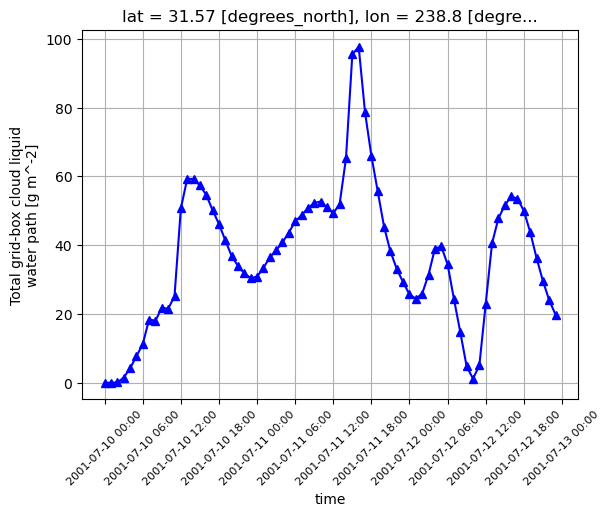

In [38]:
varname = "TGCLDLWP"
plot_time_series_latlon(ds_2d, varname=varname, jj=lat_index, ii=lon_index)

#varname = "PBLH"
#plot_time_series_latlon(ds_2d, varname=varname, jj=lat_index, ii=lon_index)

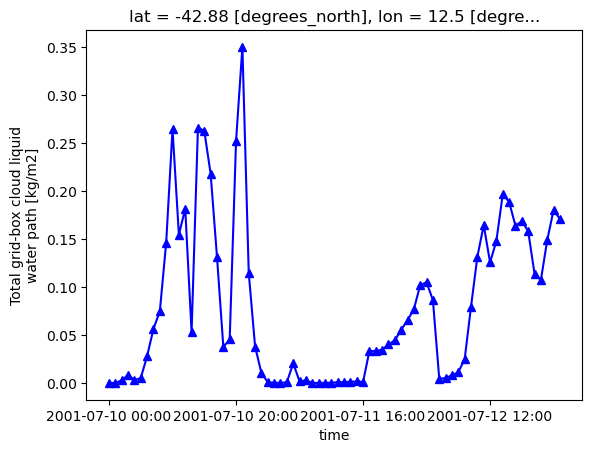

In [9]:
import nc_time_axis

varname = "TGCLDLWP"
ii=10
jj=50

var_1d = ds_2d.TGCLDLWP[:, jj, ii] #[:,:,11].plot.line(x="time")
var_1d.plot.line("b-^")
plt.show()

### 1vNt: T, Q, CLDLIQ

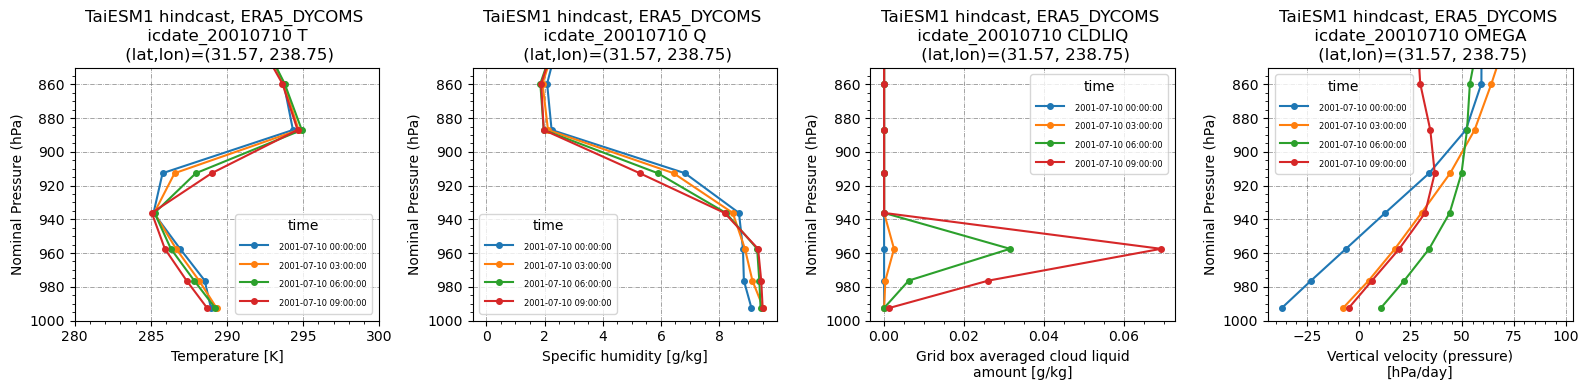

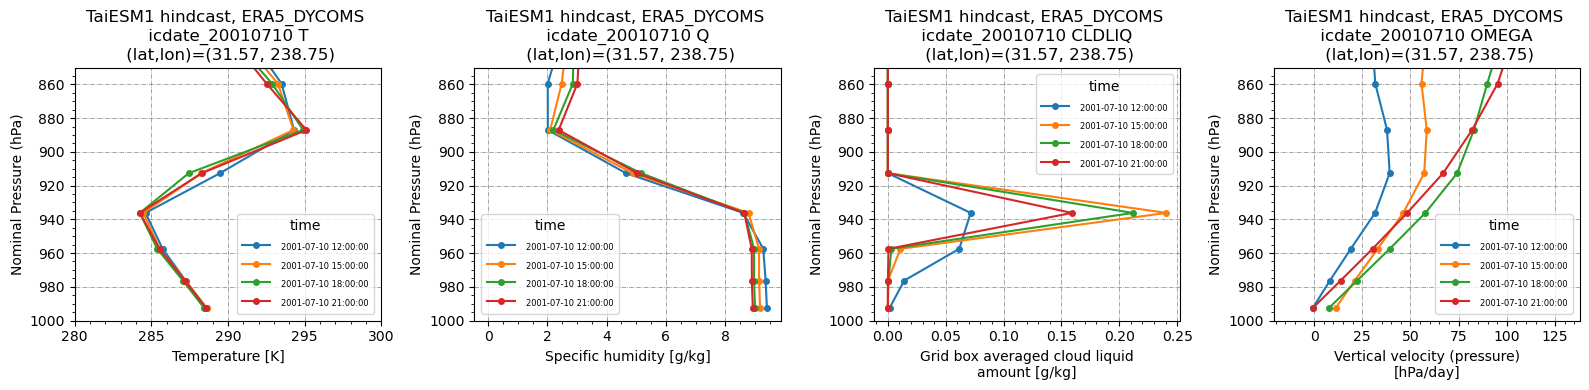

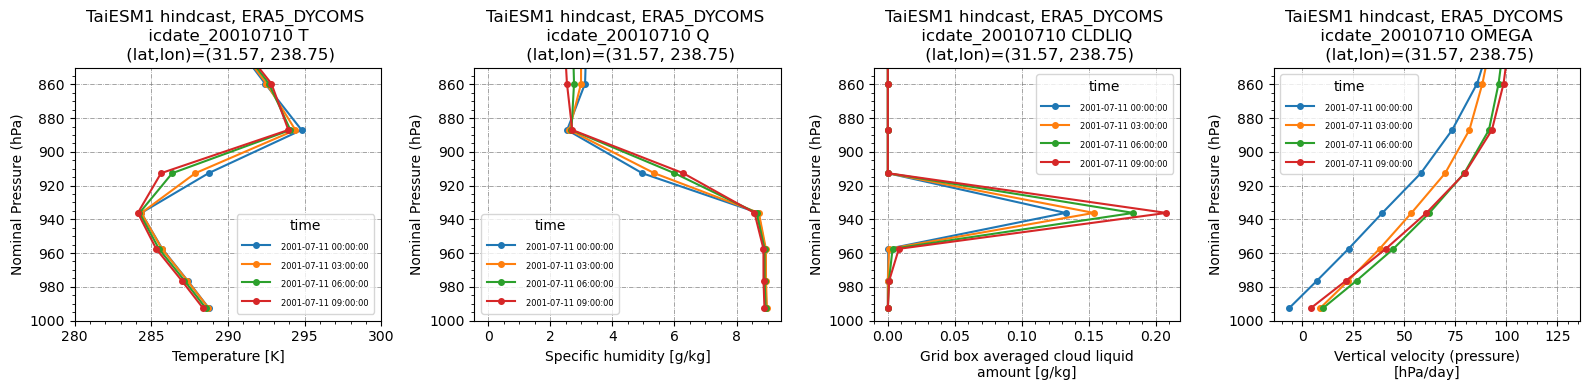

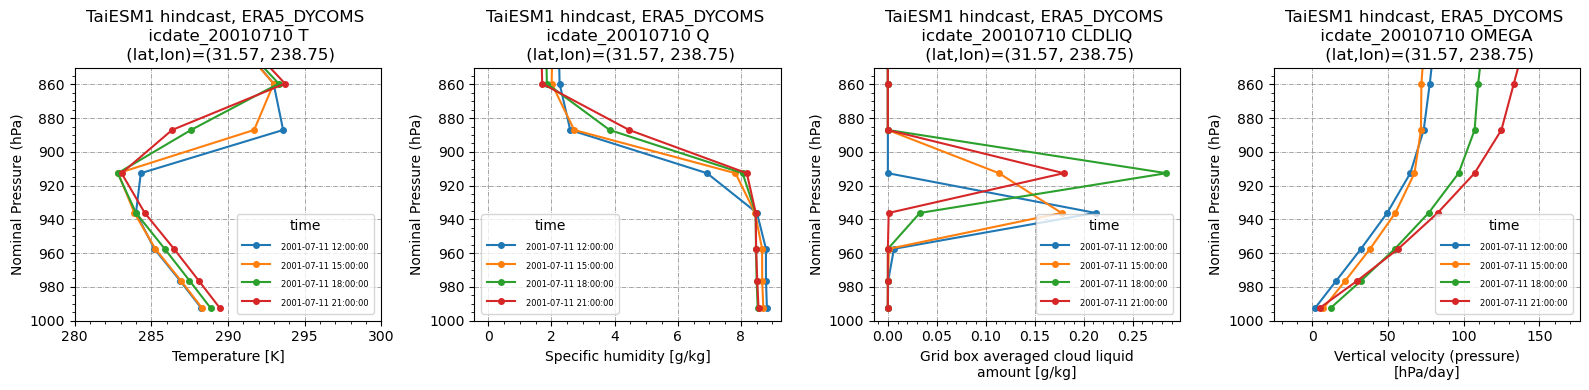

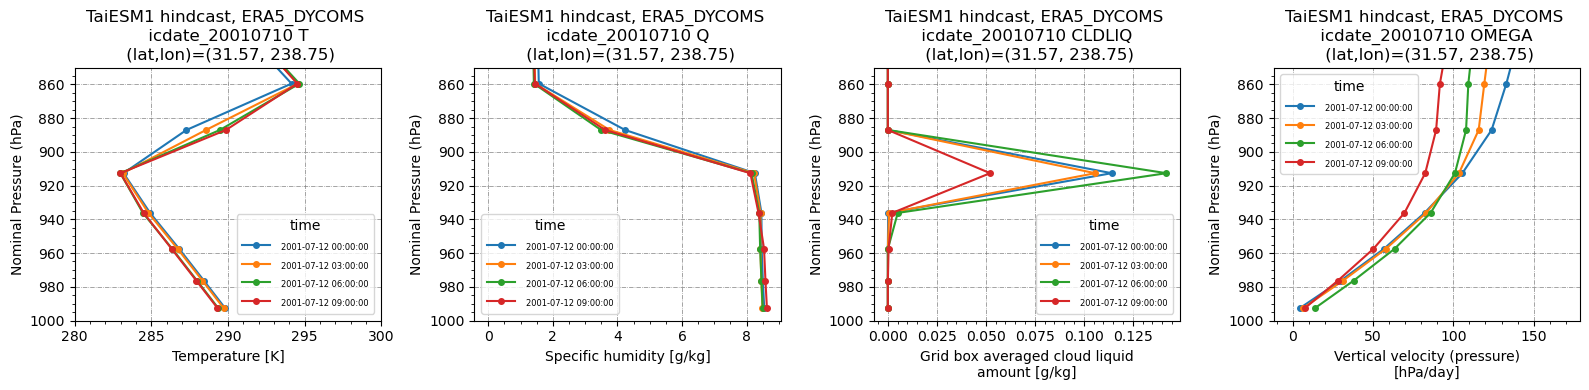

In [80]:
ttend_min=-100 ; ttend_max=300
tmin=280 ; tmax=300

xlim_custom = {
    "T": [tmin,tmax], "TBP": [tmin,tmax],  "TAP": [tmin,tmax], 
    "TTEND_TOT": [ttend_min, ttend_max], "MACPDT": [ttend_min, ttend_max], "MPDT": [ttend_min, ttend_max], "DTCORE": [ttend_min, ttend_max],
    
}
tt1=0 ; tt2=4
plot_scm_profiles_1vNt(ds_state, ['T', 'Q', 'CLDLIQ', "OMEGA"], tt1=tt1, tt2=tt2, jj=lat_index, ii=lon_index, xlim=xlim_custom, title=title)

tt1=4 ; tt2=8
plot_scm_profiles_1vNt(ds_state, ['T', 'Q', 'CLDLIQ', "OMEGA"], tt1=tt1, tt2=tt2, jj=lat_index, ii=lon_index, xlim=xlim_custom, title=title)

tt1=8 ; tt2=12
plot_scm_profiles_1vNt(ds_state, ['T', 'Q', 'CLDLIQ', "OMEGA"], tt1=tt1, tt2=tt2, jj=lat_index, ii=lon_index, xlim=xlim_custom, title=title)

tt1=12 ; tt2=16
plot_scm_profiles_1vNt(ds_state, ['T', 'Q', 'CLDLIQ', "OMEGA"], tt1=tt1, tt2=tt2, jj=lat_index, ii=lon_index, xlim=xlim_custom, title=title)

tt1=16 ; tt2=20
plot_scm_profiles_1vNt(ds_state, ['T', 'Q', 'CLDLIQ', "OMEGA"], tt1=tt1, tt2=tt2, jj=lat_index, ii=lon_index, xlim=xlim_custom, title=title)

### T tendency

/tmp/ipykernel_1934732/3837351897.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


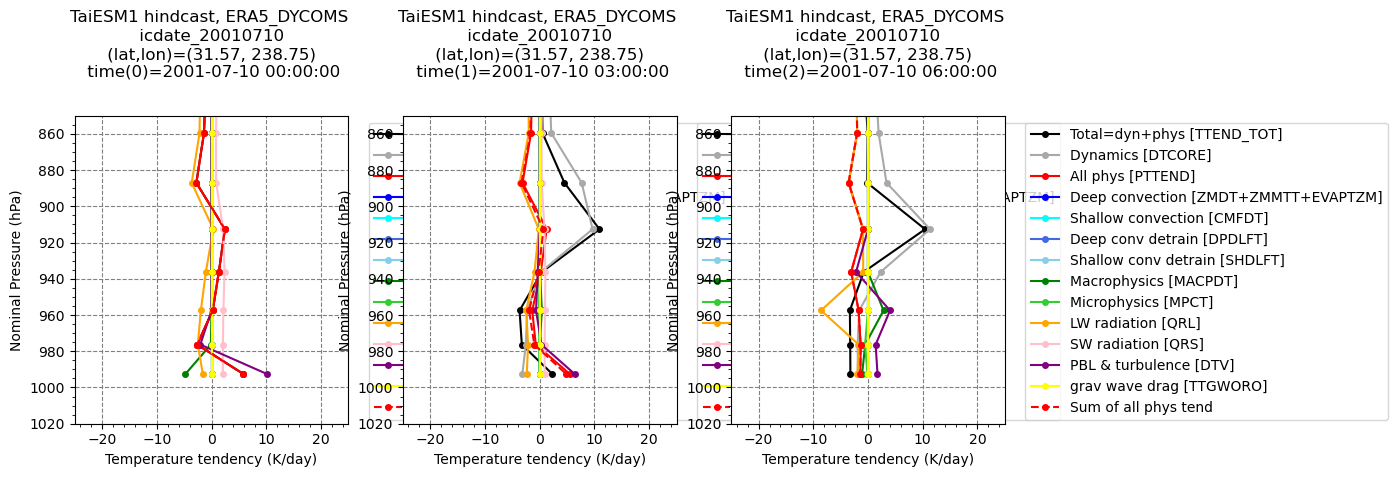

/tmp/ipykernel_1934732/3837351897.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


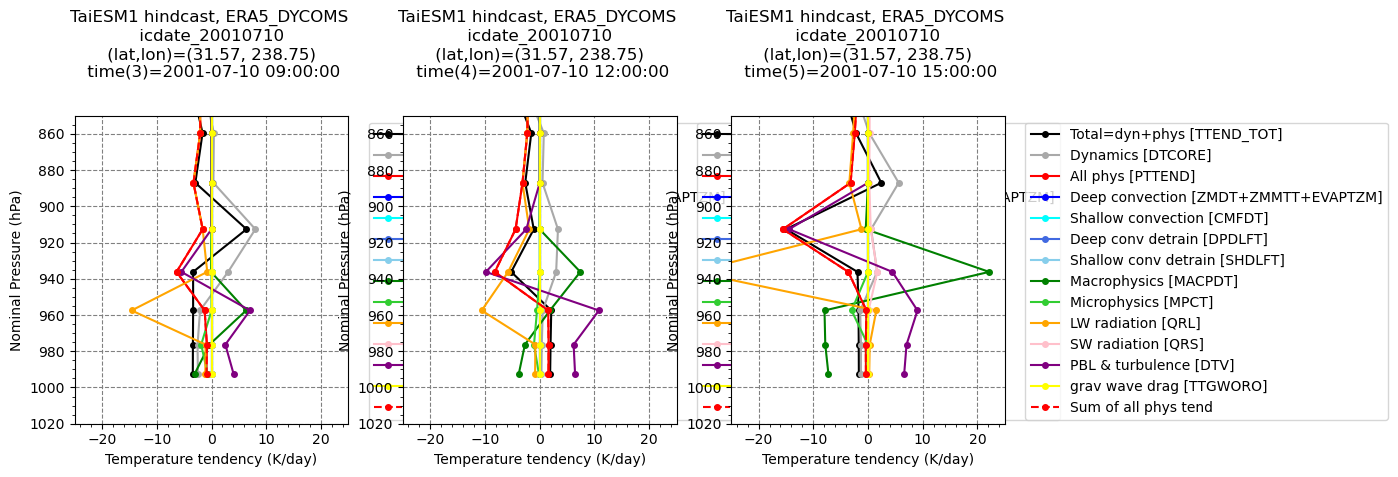

/tmp/ipykernel_1934732/3837351897.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


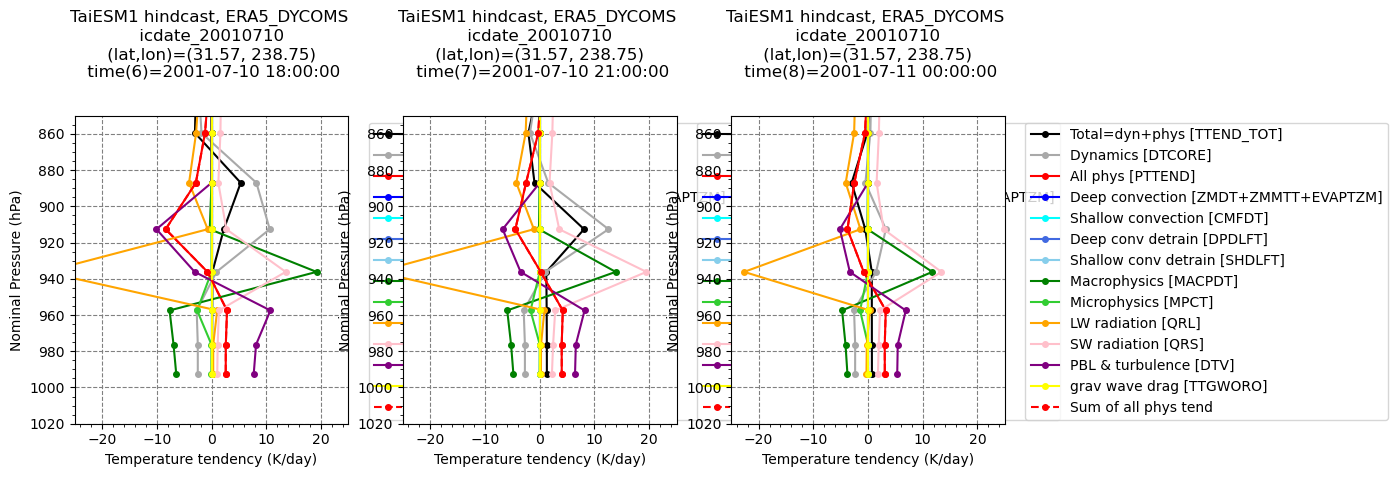

/tmp/ipykernel_1934732/3837351897.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


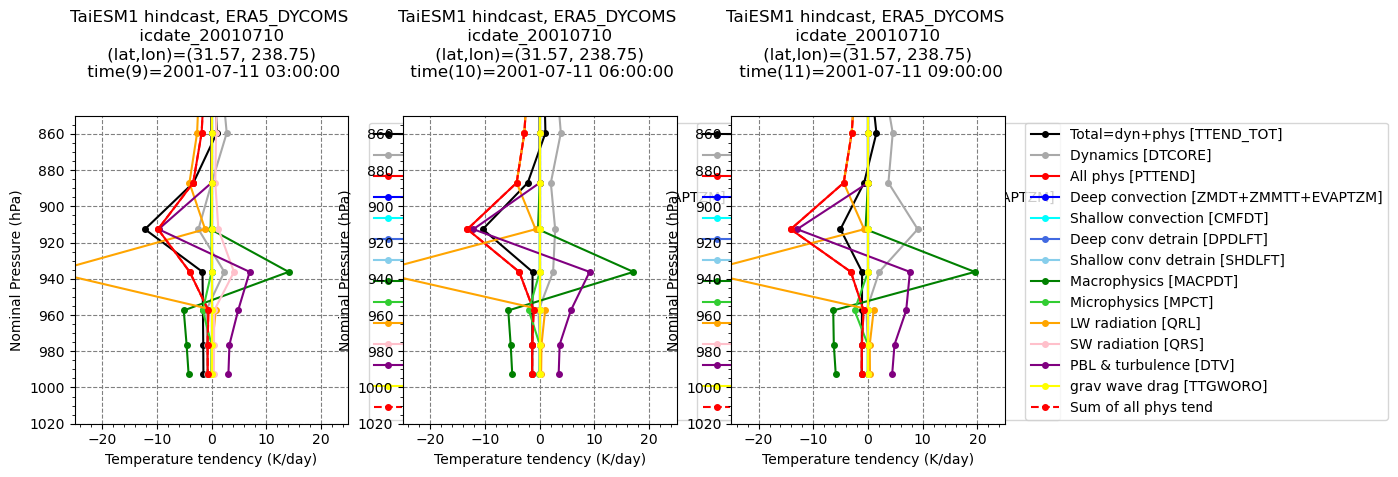

In [87]:
varnames = set_profile_varnames('DT_budget')
xlim = [-25, 25]

tt_steps_all = [np.arange(0,3), np.arange(3,6), np.arange(6, 9), np.arange(9,12)]

for tt_steps in tt_steps_all:
    plot_scm_profiles_Nv1t (ds_Ttend, varnames, tt_steps=tt_steps, jj=lat_index, ii=lon_index, xlabel="Temperature tendency", title=title, xlim=xlim)


### QV tendency

/tmp/ipykernel_1934732/157704367.py:201: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


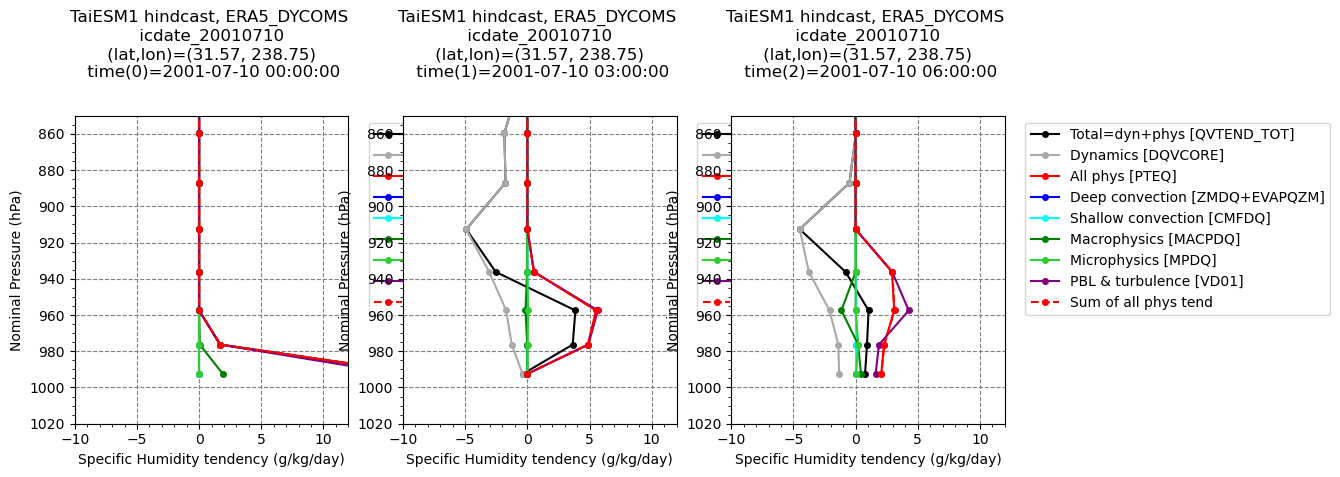

/tmp/ipykernel_1934732/157704367.py:201: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


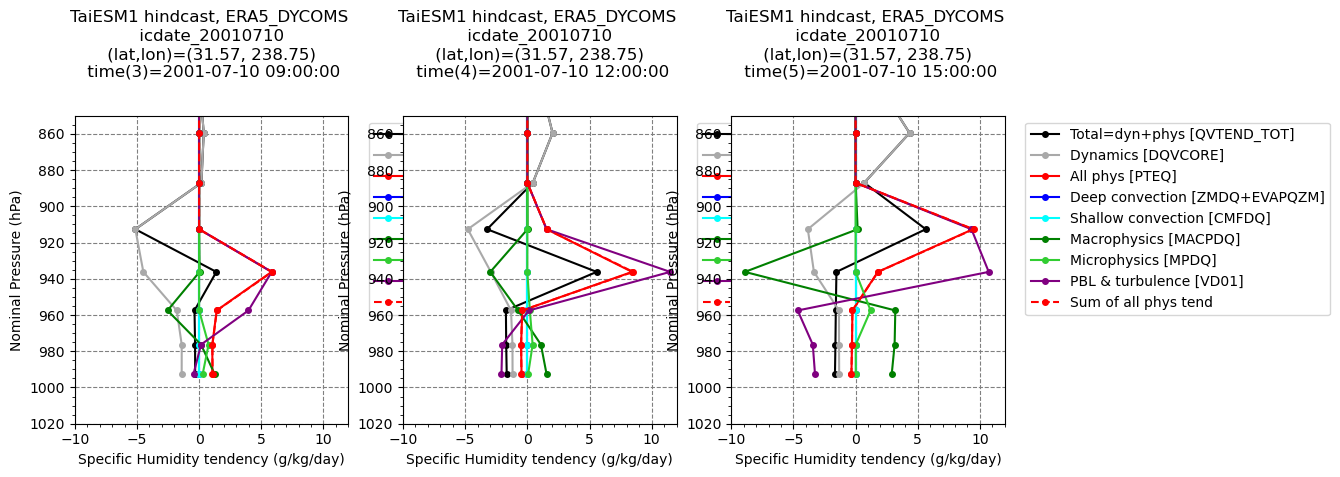

/tmp/ipykernel_1934732/157704367.py:201: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


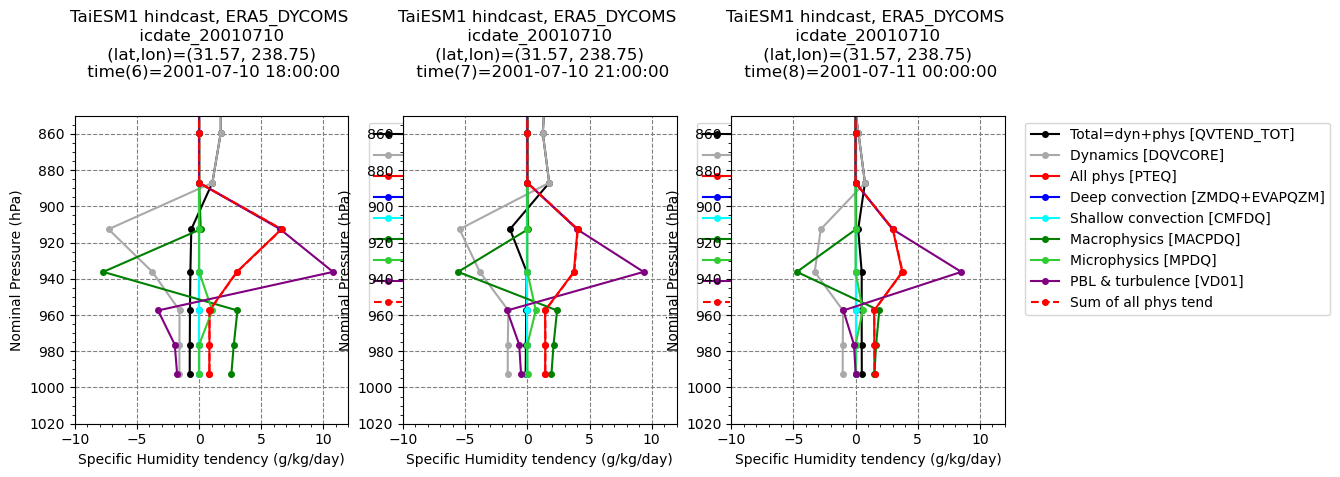

/tmp/ipykernel_1934732/157704367.py:201: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


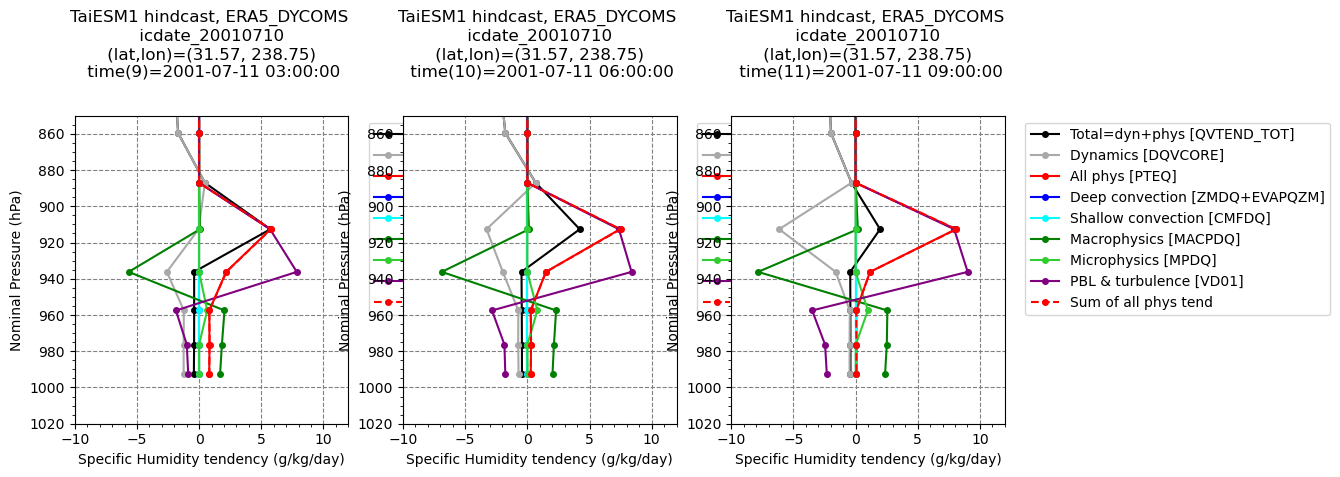

In [109]:
varnames = set_profile_varnames('DQV_budget')

#tt_steps = np.arange(0,3)
tt_steps_all = [np.arange(0,3), np.arange(3,6), np.arange(6, 9), np.arange(9,12)]

xlim = [-10, 12]

for tt_steps in tt_steps_all:
    plot_scm_profiles_Nv1t (ds_Qtend, varnames, tt_steps=tt_steps, jj=lat_index, ii=lon_index, xlabel="Specific Humidity tendency", title=title, xlim=xlim)


### QL tendency

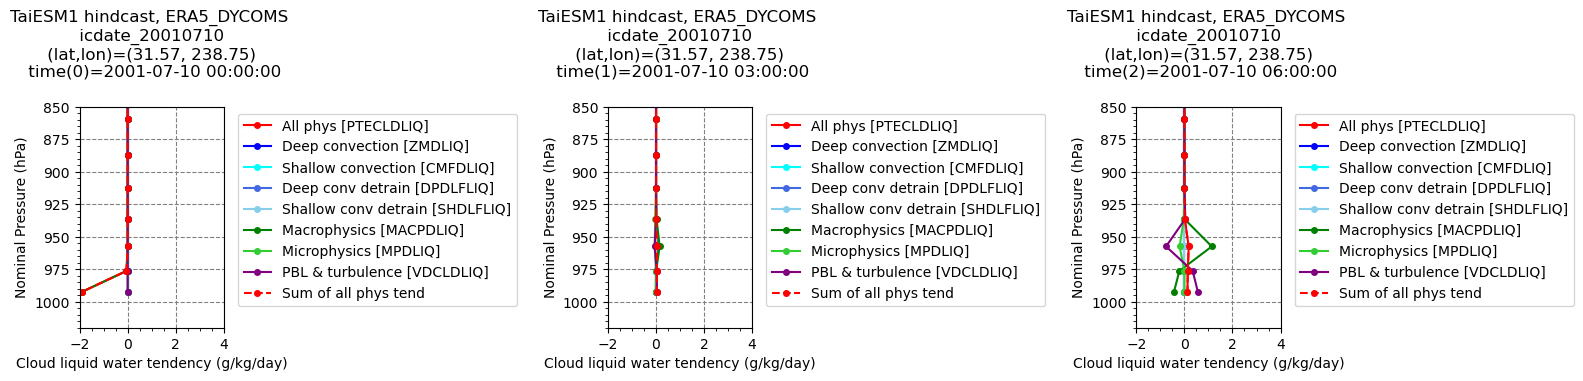

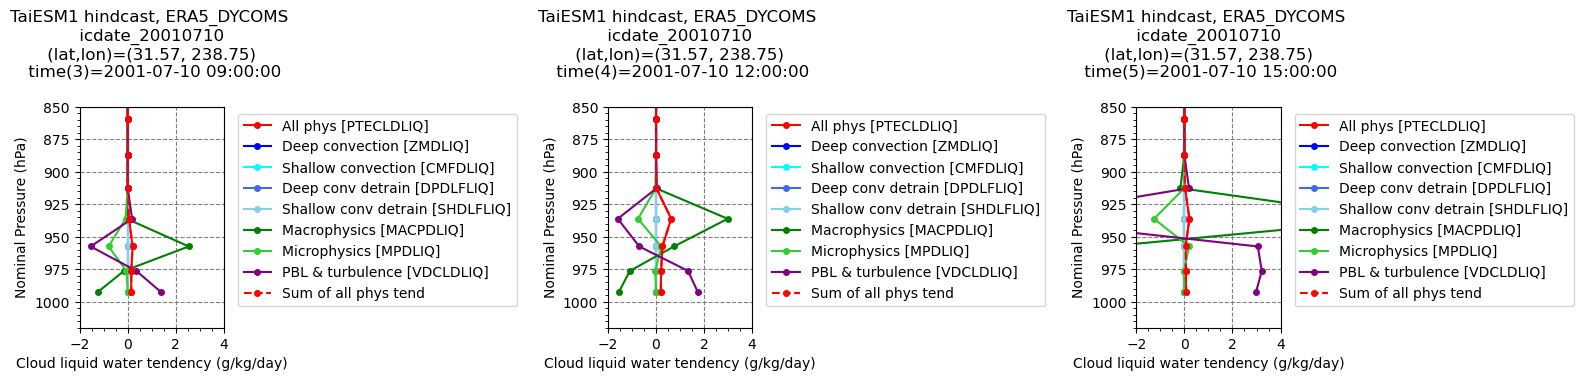

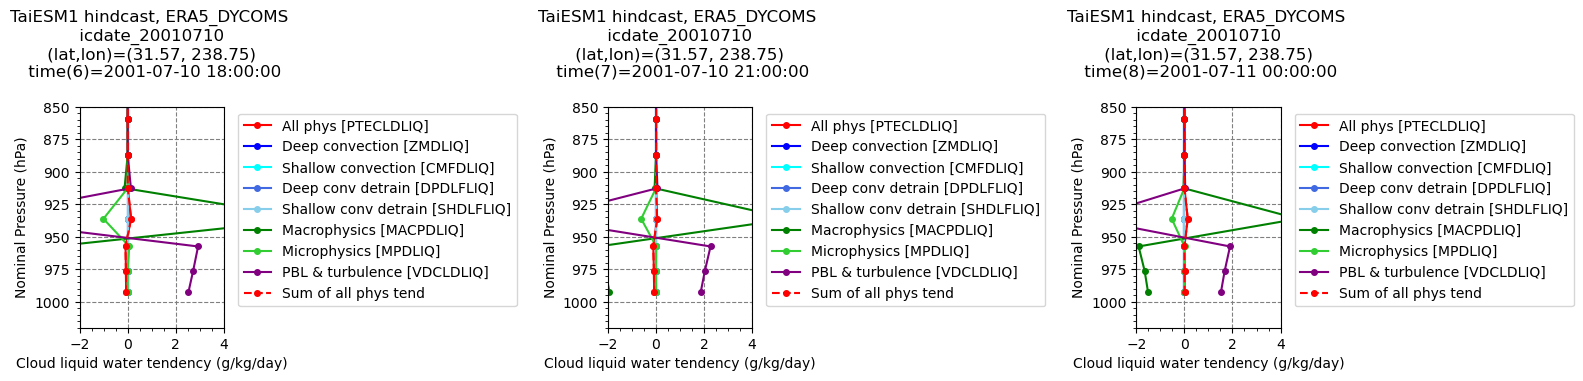

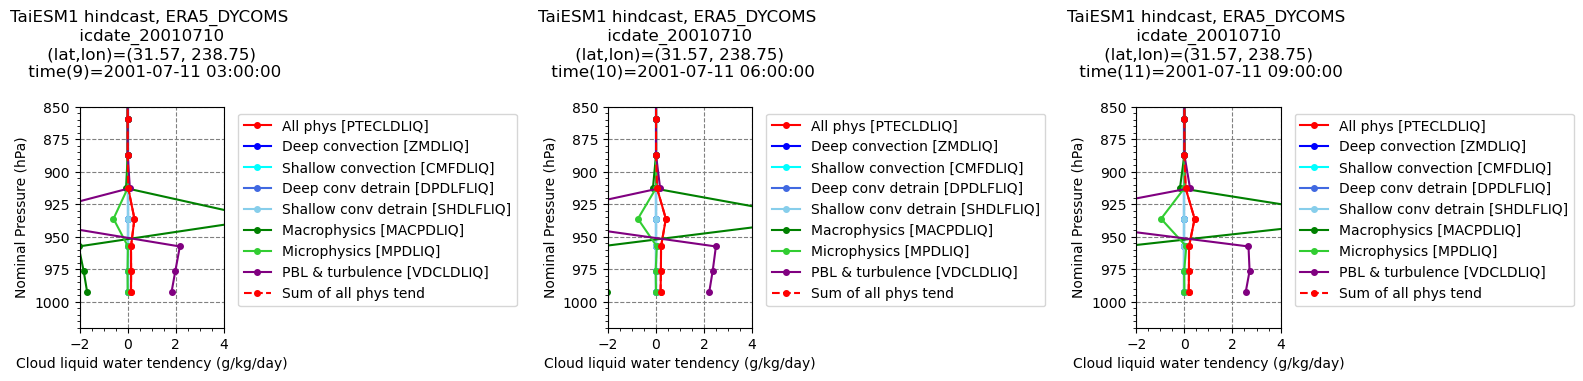

In [114]:
varnames = set_profile_varnames('DQL_budget')

#tt_steps = np.arange(0,3)
tt_steps_all = [np.arange(0,3), np.arange(3,6), np.arange(6, 9), np.arange(9,12)]

#xlim = [-10,10]
xlim = [-2,4]

for tt_steps in tt_steps_all:
    plot_scm_profiles_Nv1t (ds_Qtend, varnames, tt_steps=tt_steps, jj=lat_index, ii=lon_index, xlabel="Cloud liquid water tendency", title=title, 
                        fig_orientation="custom", figsize_width=figsize_width, figsize_height=figsize_height,
                        xlim=xlim)


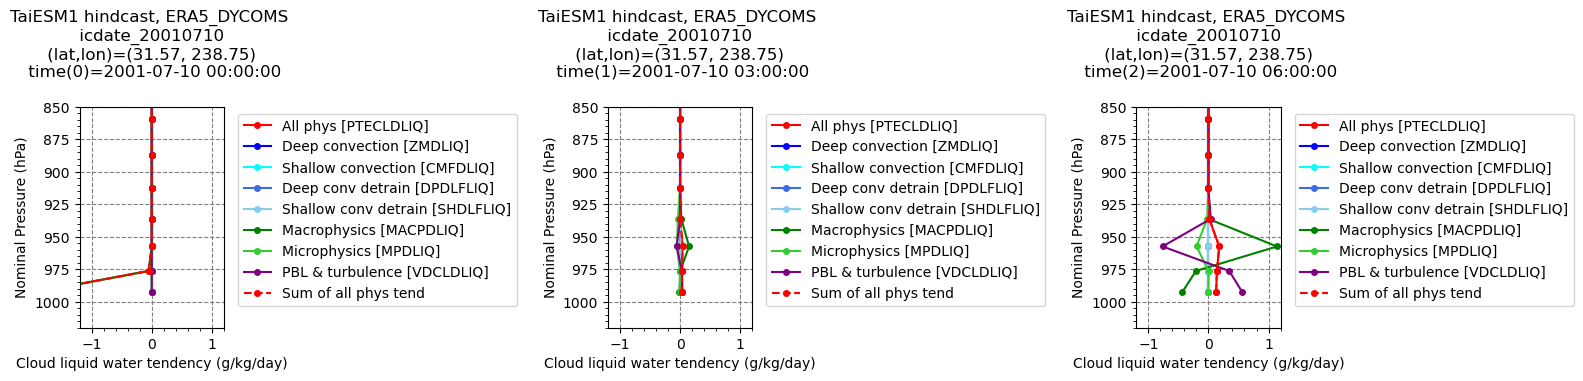

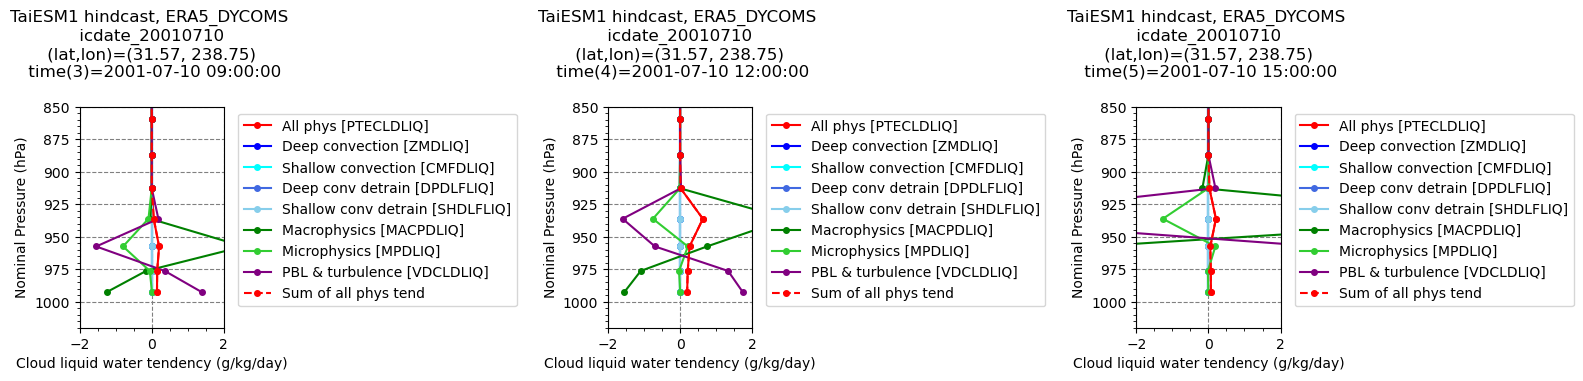

In [54]:
varnames = set_profile_varnames('DQL_budget')

figsize_width=16
figsize_height=4
xlim=[-1.2,1.2]

tt_steps = [0,1,2]
plot_scm_profiles_Nv1t (ds_Qtend, varnames, tt_steps=tt_steps, jj=lat_index, ii=lon_index, xlabel="Cloud liquid water tendency", title=title, 
                        fig_orientation="custom", figsize_width=figsize_width, figsize_height=figsize_height,
                        xlim=xlim)

tt_steps = [3,4,5]
xlim=[-2,2]
plot_scm_profiles_Nv1t (ds_Qtend, varnames, tt_steps=tt_steps, jj=lat_index, ii=lon_index, xlabel="Cloud liquid water tendency", title=title, 
                        fig_orientation="custom", figsize_width=figsize_width, figsize_height=figsize_height,
                        xlim=xlim)

### QI tendency

## Print out variable profiles

In [13]:
#--- read SCM data
choice = "RF01_modIOP_psflx"
ds_scm = read_scm_ds(choice)

#--- variables
varnames_diag=["CLOUD",'CLDLIQ',"MACPDLIQ","MPDLIQ"]
ds_scm1 = yhc.diagnose_var(ds_scm, varnames_diag)

ds_name="ds_scm"
varnames = ['TBP','T','TAP',"TTEND_TOT"]
dim_name = "[tt,:,0,0]"
text_all = ', '.join([f"{ds_name}.{var}{dim_name}" for var in varnames])
print(text_all)

#--- given varnames_diag, I want to print them out
tt=0
yhc.print_1d_arrays(ds_scm.TBP[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0], ds_scm.DTCORE[tt,:,0,0])

ds_scm.TBP[tt,:,0,0], ds_scm.T[tt,:,0,0], ds_scm.TAP[tt,:,0,0], ds_scm.TTEND_TOT[tt,:,0,0]
Index	lev	TBP	TAP	TTEND_TOT	DTCORE
1	3.64346569404006	234.0	233.9589385986328	-3.421822839300148e-05	0.0
2	7.594819646328688	234.0	233.96035766601562	-3.3037300454452634e-05	0.0
3	14.356632251292467	233.2023162841797	233.1671905517578	-2.9276781788212247e-05	0.0
4	24.612220004200935	226.12950134277344	226.11270141601562	-1.4004617696627975e-05	0.0
5	38.26829977333546	222.0059814453125	221.9962615966797	-8.10399797046557e-06	0.0
6	54.59547974169254	218.92538452148438	218.9180908203125	-6.075683813833166e-06	0.0
7	72.01245054602623	209.34767150878906	209.3515167236328	3.1974175271898275e-06	0.0
8	87.82123029232025	209.20156860351562	209.2028350830078	1.0484484391781734e-06	0.0
9	103.31712663173676	209.05836486816406	209.05979919433594	1.2049374618072761e-06	0.0
10	121.54724076390266	208.88987731933594	208.89312744140625	2.7050107291870518e-06	0.0
11	142.99403876066208	212.67398071289062	212.6753997